xG Lollipop Plots - SonOfACorner

In [1]:
# %%
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

###FONTS###

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

font_manager.findfont("Rubik") # Test with "Special Elite" too                
#####

'/Users/andylyford/Library/Fonts/Rubik-Regular.ttf'

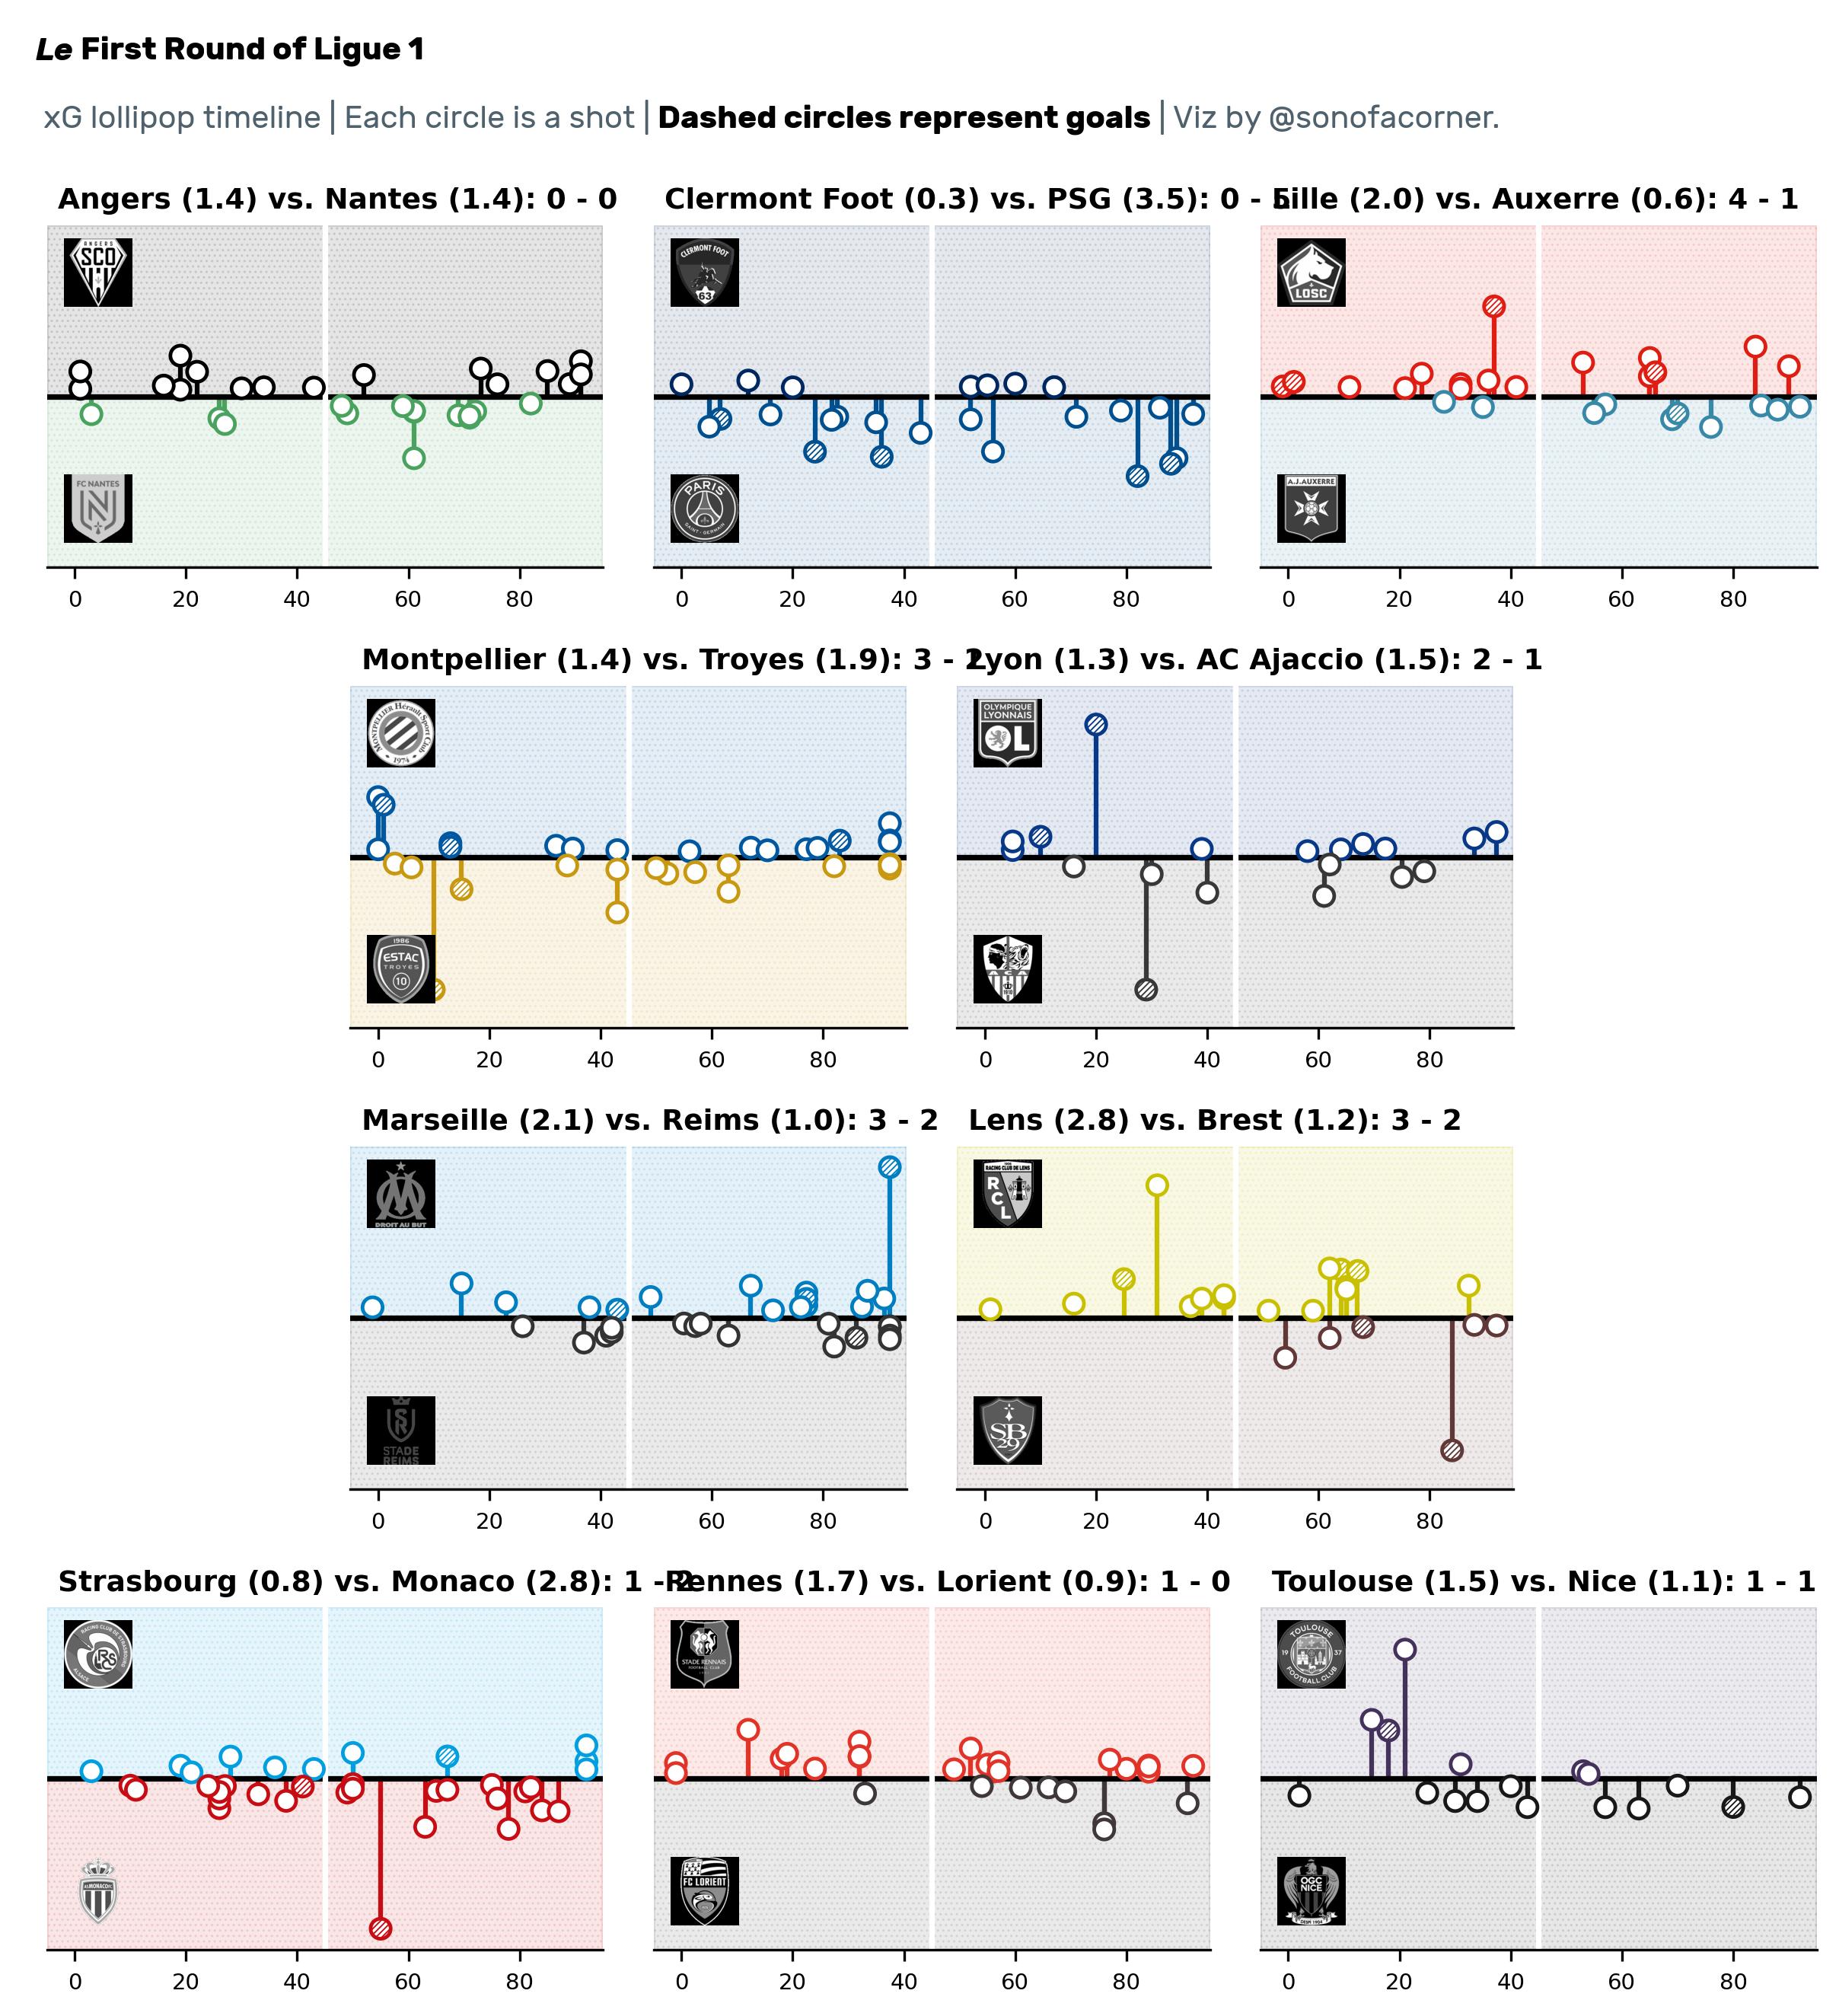

In [2]:
# --- Read and transform the data

df = pd.read_csv('data/08082022_ligue1_shots.csv', index_col = 0)
df['min'] = df['min'].astype(int)
df['xG'] = df['xG'].astype(float)
# Rename PSG 
df = df.replace({
    'teamName': {
        'Paris Saint-Germain': 'PSG'
    }
})


# ----------------------------------------------------------------
# Function to plot the xG match axes

def plot_axes_xg_by_match(ax, fig, match_id, data=df):
    '''
    This function plots the xG lollipop chart for a given match
    id.
    '''
    df = data.copy()
    match_df = df[df['match_id'] == match_id].reset_index(drop=True)
    match_df.sort_values(by='min', ascending=True).reset_index(drop=True)

    home_conditional = (match_df['venue'] == 'H')
    away_conditional = (match_df['venue'] == 'A')

    # -- Clean up the axes
    ax.set_ylim(-1.05,1.05)
    ax.set_xlim(-5,95)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks([])
    #ax.xaxis.set_ticks(
        #[x for x in range(-2,45,10)] + [x for x in range(52,102,10)],
        #labels=[x for x in range(0,91,10)]
   # )
    ax.tick_params(labelsize=7)

    plt.rcParams['hatch.linewidth'] = 0.45

    home_color = match_df[home_conditional]['teamColor'].iloc[0]
    for index, shot in enumerate(match_df[home_conditional]['xG']):
        minute = match_df[home_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        ax.plot([minute + offset_x, minute + offset_x], [0, shot], color=home_color)
        if match_df[home_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
        else:
            hatch = '/////////////'
        ax.scatter([minute + offset_x], [shot + .025], marker='o', s=40, hatch=hatch, 
                color="white", zorder=3, lw=1.15, ec=home_color)

    away_color = match_df[away_conditional]['teamColor'].iloc[0]
    for index, shot in enumerate(match_df[away_conditional]['xG']):
        minute = match_df[away_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        ax.plot([minute + offset_x, minute + offset_x], [0, -1*shot], color=away_color)
        if match_df[away_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
        else:
            hatch = '/////////////'
        ax.scatter([minute + offset_x], [-1*shot - .025], marker='o', s=40, hatch=hatch, 
                color="white", zorder=3, lw=1.15, ec=away_color)

    # --- Make it pretty ---
    ax.plot([-5,95], [0,0], color='black', lw=1.75)
    ax.plot([45,45], [-1.05,1.05], color='white', lw=1.75, zorder=2)
    ax.fill_between(
        x=[-5,95], y1=[0], y2=[1.05],
        color=home_color, alpha=0.1, zorder=1,
        hatch="......."
    )
    ax.fill_between(
        x=[-5,95], y1=[0], y2=[-1.05],
        color=away_color, alpha=0.1, zorder=1,
        hatch="......."
    )

    # --- Add the logos and legend ---
    home_team_id = match_df[home_conditional]['teamId'].iloc[0]
    away_team_id = match_df[away_conditional]['teamId'].iloc[0]
    home_team_name = match_df[home_conditional]['teamName'].iloc[0]
    away_team_name = match_df[away_conditional]['teamName'].iloc[0]

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # Native data to normalized data coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

    ax_coords = DC_to_NFC([-2, .55])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = 'W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{home_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    ax_coords = DC_to_NFC([-2, -.9])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = 'W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{away_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    # --- Compute goals and xG
    home_xG = match_df[home_conditional]['xG'].sum()
    away_xG = match_df[away_conditional]['xG'].sum()
    home_goals = (match_df[home_conditional]['eventType'] == 'Goal').sum()
    away_goals = (match_df[away_conditional]['eventType'] == 'Goal').sum()

    ax.annotate(
        xy=(0.02, 1.05),
        text=f'{home_team_name} ({home_xG:.1f}) vs. {away_team_name} ({away_xG:.1f}): {home_goals} - {away_goals}',
        xycoords='axes fraction',
        weight='bold',
        size=9
    )

    return ax


# --- The Final Visual

layout_ = '''
    AABBCC
    ......
    .GGHH.
    ......
    .IIJJ.
    ......
    DDEEFF
'''

height_ratios = [1,.05,1,.05,1,.05,1]

f = plt.figure(figsize=(10,10), dpi=300)
axs = f.subplot_mosaic(
    layout_, 
    gridspec_kw={
        'height_ratios':height_ratios,
        'hspace': 0.25
    }
)

counter = 0
df = df.sort_values(by='match_id').reset_index(drop=True)
matches = list(df['match_id'].unique())
for k, ax in axs.items():
    match_id = matches[counter]
    plot_axes_xg_by_match(ax, f, match_id=match_id, data=df)
    counter += 1


fig_text(
    x = 0.12, y = .95, 
    s = "<Le> First Round of Ligue 1",
    highlight_textprops=[{"style":"italic"}],
    va = "bottom", ha = "left",
    fontsize = 16, color = "black", font = "Rubik", weight = "bold"
)
fig_text(
	x = 0.12, y = .92, 
    s = " xG lollipop timeline | Each circle is a shot | <Dashed circles represent goals> | Viz by @sonofacorner.",
    highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "left",
	fontsize = 12, color = "#4E616C", font = "Rubik"
)

plt.savefig(
	"figures/08082022_ligue1_round1.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/08082022_ligue1_round1_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)